In this notebook, we will pick a dataset with 6 independent variables and do principal component analysis on the independent variables. Using the PCA results, we will reduce the dimensionality of the data set. Finally we will construct simple linear regression models with the original independent variables and contrast it against a model with the new reduced set of variables constructed using PCA

## Import Libraries

In [1]:
import numpy as np   
from sklearn.linear_model import LinearRegression
import pandas as pd    
import matplotlib.pyplot as plt 
%matplotlib inline 
import seaborn as sns
from sklearn.decomposition import PCA

## Load and review data

In [2]:
cData = pd.read_csv("auto-mpg.csv")  
cData.shape

(398, 9)

In [3]:
# 8 variables: 
#
# MPG (miles per gallon), 
# cylinders, 
# engine displacement (cu. inches), 
# horsepower,
# vehicle weight (lbs.), 
# time to accelerate from O to 60 mph (sec.),
# model year (modulo 100), and 
# origin of car (1. American, 2. European,3. Japanese).
#
# Also provided are the car labels (types) 
# Missing data values are marked by series of question marks.

cData.head()

,mpg,cyl,disp,hp,wt,acc,yr,origin,car name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


Since the focus is on the PCA technique, we will drop the non-numerica variables. Remember 'origin' is categorical.

In [5]:
#dropping/ignoring car_name  and origin
cData = cData.drop(['car name','origin'], axis=1)
cData.head()

,mpg,cyl,disp,hp,wt,acc,yr
0,18.0,8,307.0,130,3504,12.0,70
1,15.0,8,350.0,165,3693,11.5,70
2,18.0,8,318.0,150,3436,11.0,70
3,16.0,8,304.0,150,3433,12.0,70
4,17.0,8,302.0,140,3449,10.5,70


## Dealing with Missing Values

In [9]:
# isdigit()? on 'horsepower' 
hpIsDigit = pd.DataFrame(cData.hp.str.isdigit())  # if the string is made of digits store True else False

#print isDigit = False!
cData[hpIsDigit['hp'] == False]   # from temp take only those rows where hp has false

,mpg,cyl,disp,hp,wt,acc,yr
32,25.0,4,98.0,?,2046,19.0,71
126,21.0,6,200.0,?,2875,17.0,74
330,40.9,4,85.0,?,1835,17.3,80
336,23.6,4,140.0,?,2905,14.3,80
354,34.5,4,100.0,?,2320,15.8,81
374,23.0,4,151.0,?,3035,20.5,82


There are various ways to handle missing values. Drop the rows, replace missing values with median values etc. of the 398 rows 6 have NAN in the hp column. We could drop those 6 rows - which might not be a good idea under all situations. Here, we will replace them with their median values. First replace '?' with NaN and then replace NaN with median


In [11]:
cData = cData.replace('?', np.nan)
cData[hpIsDigit['hp'] == False] 

,mpg,cyl,disp,hp,wt,acc,yr
32,25.0,4,98.0,NaN,2046,19.0,71
126,21.0,6,200.0,NaN,2875,17.0,74
330,40.9,4,85.0,NaN,1835,17.3,80
336,23.6,4,140.0,NaN,2905,14.3,80
354,34.5,4,100.0,NaN,2320,15.8,81
374,23.0,4,151.0,NaN,3035,20.5,82


In [13]:
#instead of dropping the rows, lets replace the missing values with median value. 
cData.median()

mpg       23.0
cyl        4.0
disp     148.5
hp        93.5
wt      2803.5
acc       15.5
yr        76.0
dtype: float64

In [15]:
# replace the missing values with median value.
# Note, we do not need to specify the column names below
# every column's missing value is replaced with that column's median respectively  (axis =0 means columnwise)
#cData = cData.fillna(cData.median())

medianFiller = lambda x: x.fillna(x.median())
cData = cData.apply(medianFiller,axis=0)

cData['hp'] = cData['hp'].astype('float64')  # converting the hp column from object / string type to float


## BiVariate Plots

A bivariate analysis among the different independent variables can be done using scatter matrix plot. Seaborn libs create a dashboard reflecting useful information about the dimensions. The result can be stored as a .png file. 

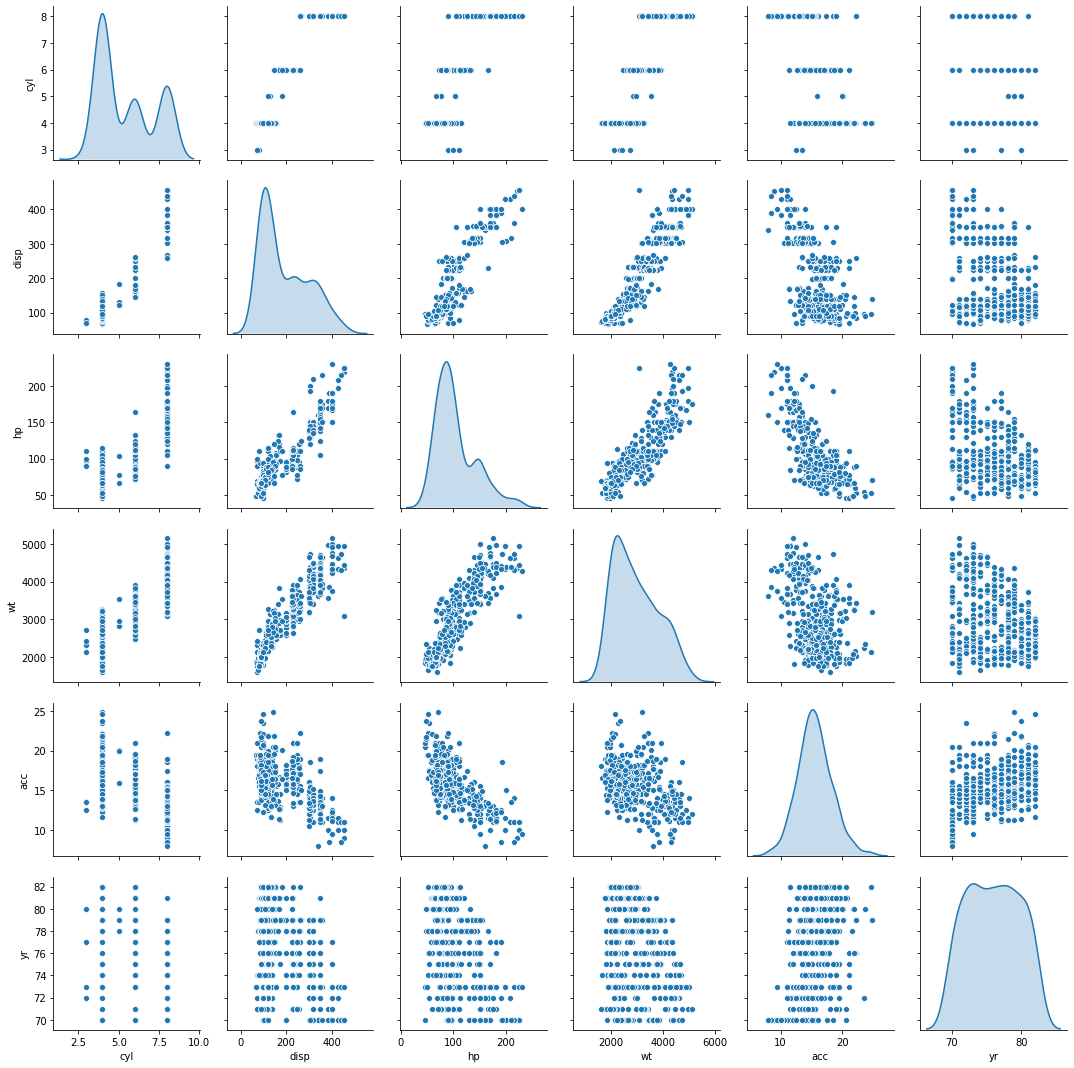

In [17]:
# independant variables
X = cData.drop(['mpg'], axis=1)
# the dependent variable
y = cData[['mpg']]

sns.pairplot(X, diag_kind='kde')   # to plot density curve instead of histogram on the diag

In [18]:
from scipy.stats import zscore
XScaled=X.apply(zscore)
XScaled.head()

,cyl,disp,hp,wt,acc,yr
0,1.498191,1.090604,0.673118,0.630870,-1.295498,-1.627426
1,1.498191,1.503514,1.589958,0.854333,-1.477038,-1.627426
2,1.498191,1.196232,1.197027,0.550470,-1.658577,-1.627426
3,1.498191,1.061796,1.197027,0.546923,-1.295498,-1.627426
4,1.498191,1.042591,0.935072,0.565841,-1.840117,-1.627426


In [20]:
covMatrix = np.cov(XScaled,rowvar=False)
print(covMatrix)

[[ 1.00251889  0.95311615  0.84340357  0.89827376 -0.50669259 -0.34962425]
 [ 0.95311615  1.00251889  0.89803457  0.93517383 -0.54505356 -0.37109656]
 [ 0.84340357  0.89803457  1.00251889  0.86461476 -0.68831918 -0.41477495]
 [ 0.89827376  0.93517383  0.86461476  1.00251889 -0.41850885 -0.30733654]
 [-0.50669259 -0.54505356 -0.68831918 -0.41850885  1.00251889  0.28886274]
 [-0.34962425 -0.37109656 -0.41477495 -0.30733654  0.28886274  1.00251889]]


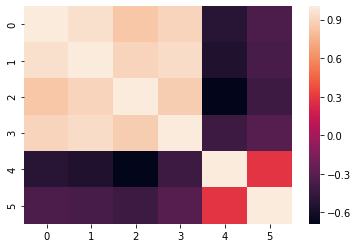

In [21]:
sns.heatmap(covMatrix)

In [22]:
from sklearn.decomposition import PCA
pca = PCA(n_components=6)
pca.fit(XScaled)

PCA(copy=True, iterated_power='auto', n_components=6, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

The eigen Values

In [38]:
print(pca.explained_variance_)

[4.26378678 0.84068225 0.67499578 0.13552589 0.06386533 0.03625731]


The eigen Vectors

In [24]:
print(pca.components_)

[[ 0.45509041  0.46913807  0.46318283  0.44618821 -0.32466834 -0.23188446]
 [ 0.18276349  0.16077095  0.0139189   0.25676595  0.21039209  0.9112425 ]
 [ 0.17104591  0.13443134 -0.12440857  0.27156481  0.86752316 -0.33294164]
 [-0.65709523 -0.18742114  0.62819714  0.33868744  0.15214558  0.02469974]
 [ 0.28804531 -0.00141408  0.60418441 -0.68887559  0.27061128  0.06487726]
 [-0.46420823  0.83717483 -0.10059817 -0.26829299  0.0367486   0.01405118]]


And the percentage of variation explained by each eigen Vector

In [26]:
print(pca.explained_variance_ratio_)

[0.70884563 0.13976166 0.11221664 0.0225309  0.01061748 0.0060277 ]


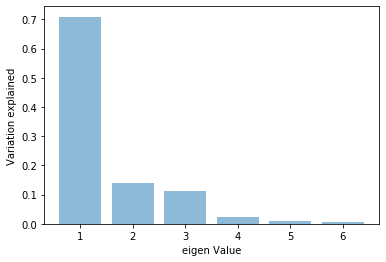

In [28]:
plt.bar(list(range(1,7)),pca.explained_variance_ratio_,alpha=0.5, align='center')
plt.ylabel('Variation explained')
plt.xlabel('eigen Value')
plt.show()

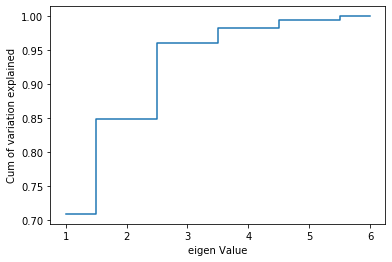

In [29]:
plt.step(list(range(1,7)),np.cumsum(pca.explained_variance_ratio_), where='mid')
plt.ylabel('Cum of variation explained')
plt.xlabel('eigen Value')
plt.show()

# Dimensionality Reduction

Now 3 dimensions seems very reasonable. With 3 variables we can explain over 95% of the variation in the original data!

In [30]:
pca3 = PCA(n_components=3)
pca3.fit(XScaled)
print(pca3.components_)
print(pca3.explained_variance_ratio_)
Xpca3 = pca3.transform(XScaled)

[[ 0.45509041  0.46913807  0.46318283  0.44618821 -0.32466834 -0.23188446]
 [ 0.18276349  0.16077095  0.0139189   0.25676595  0.21039209  0.9112425 ]
 [ 0.17104591  0.13443134 -0.12440857  0.27156481  0.86752316 -0.33294164]]
[0.70884563 0.13976166 0.11221664]


In [56]:
Xpca3

array([[ 2.58470158, -1.13503558, -0.09158558],
       [ 3.36172518, -1.03670689, -0.24694524],
       [ 2.95892839, -1.20779415, -0.47937758],
       ...,
       [-1.16393463,  0.71574676, -2.16248162],
       [-1.94324569,  1.32567228,  0.14526268],
       [-1.95553788,  1.41517409,  0.41668135]])

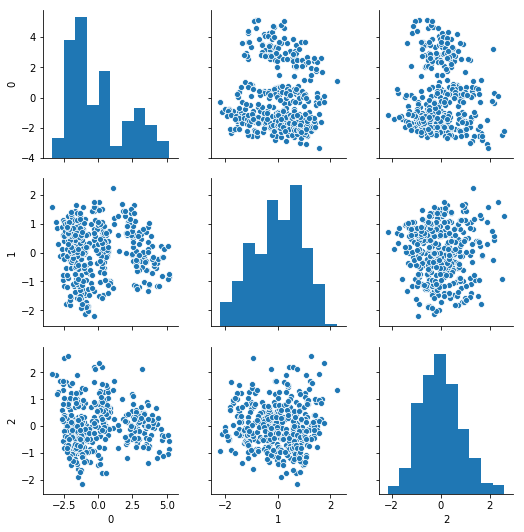

In [57]:
sns.pairplot(pd.DataFrame(Xpca3))


## Fit Linear Model

Lets construct two linear models. The first with all the 6 independent variables and the second with only the 3 new variables constructed using PCA.

In [58]:
regression_model = LinearRegression()
regression_model.fit(XScaled, y)
regression_model.score(XScaled, y)

0.8087079552406331

In [59]:
regression_model_pca = LinearRegression()
regression_model_pca.fit(Xpca3, y)
regression_model_pca.score(Xpca3, y)

0.7799909620572006

Looks like by drop reducing dimensionality by 3, we only dropped around 3% in R^2! This is insample (on training data) and hence a drop in R^2 is expected. Still seems easy to justify the dropping of variables. An out of sample (on test data), with the 3 independent variables is likely to do better since that would be less of an over-fit. 